The lasso estimator $\hat\beta(\lambda)$ for a GLM without an intercept solves the problem
\begin{equation}
    \underset{\beta \in \mathbb{R}^p}{\operatorname{minimise}} -\frac{1}{n} \mathcal{L}(\beta) + \lambda\|\beta\|_1,
\end{equation}
where $\mathcal{L}(\beta)$ is the log-likelihood, $\lambda > 0$ and $\|\beta\|_1 = \sum_{j=1}^p |\beta_j|$. When $\lambda = 0$, $\hat\beta(0)$ is the
maximum likelihood estimator. When $\lambda > 0$, the second term penalises large values of the coefficients. While this biases the estimator toward $0$, it can actually reduce the mean squared error, especially when there are many input variables.

This estimator is also convenient because it can be exactly $0$ for a subset of the coefficients, which is a form of automatic variable selection. Increasing the parameter $\lambda$ produces estimators of increasing sparsity. The penalty term is separable, i.e., it is a sum over the coefficients in the model.

In regularised regression, the penalty term depends on the magnitude of the coefficients $\sum |\beta_j|$. If features have different units, then their coefficients will have different magnitudes. Without standardisation, the lasso would disproportionately penalise features with small natural scales (which require large coefficients).

However, standardisation does not make sense for our Bradley-Terry model. All predictors in our design matrix are already on the same scale so there are no unit discrepancies to correct. Furthermore, standardising dummy variables involves dividing by their standard deviation. For a player who has played very few matches, so dividing by a small number makes the non-zero entries in that column very large. This would make it cheaper to add coefficients this player.

In [40]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Advanced Computational Maths/Statistics and Machine Learning/Tennis Modelling'
df = pd.read_csv(path + '/mensResults.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
def load_and_split(df):
    train_mask = (df['Date'].dt.year >= 2000) & (df['Date'].dt.year <= 2014)
    return df.loc[train_mask].copy()

def get_feature_lists(df, ref_player, ref_surface):
    players = sorted(list(set(df['Winner']) | set(df['Loser'])))
    surfaces = sorted(list(df['Surface'].unique()))

    # Baseline: All players except reference
    baseline_vars = [p for p in players if p != ref_player]

    # Interactions: All players * non-reference surfaces
    interaction_vars = []
    for p in players:
        for s in surfaces:
            if s != ref_surface:
                interaction_vars.append(f"{p}_{s}")

    return baseline_vars, interaction_vars

def build_doubled_sparse_matrix(df, baseline_vars, interaction_vars, ref_surface):
    '''
    Creates a dataset with 2 rows per match:
    1. Winner - Loser (y=1)
    2. Loser - Winner (y=0)
    '''
    N_matches = len(df)
    n_base = len(baseline_vars)
    n_inter = len(interaction_vars)

    # Maps
    base_map = {p: i for i, p in enumerate(baseline_vars)}
    inter_map = {feat: (i + n_base) for i, feat in enumerate(interaction_vars)}

    # Arrays for iteration
    winners = df['Winner'].values
    losers = df['Loser'].values
    surfaces = df['Surface'].values

    # Lists for CSR construction
    rows, cols, data = [], [], []

    # We will generate 2 rows per match.
    # Row 2*i is (Winner - Loser). Row 2*i + 1 is (Loser - Winner).

    for i in range(N_matches):
        w, l, s = winners[i], losers[i], surfaces[i]

        row_pos = 2 * i      # y=1 index
        row_neg = 2 * i + 1  # y=0 index

        def add_features(player, sign):
            # Baseline
            if player in base_map:
                idx = base_map[player]
                # Positive Row
                rows.append(row_pos); cols.append(idx); data.append(sign)
                # Negative Row (opposite sign)
                rows.append(row_neg); cols.append(idx); data.append(-sign)

            # Interaction
            if s != ref_surface:
                feat = f"{player}_{s}"
                if feat in inter_map:
                    idx = inter_map[feat]
                    rows.append(row_pos); cols.append(idx); data.append(sign)
                    rows.append(row_neg); cols.append(idx); data.append(-sign)

        # Add Winner (+1 in pos row, -1 in neg row)
        add_features(w, 1)

        # Add Loser (-1 in pos row, +1 in neg row)
        add_features(l, -1)

    # Build Matrix
    # Shape is (2*N, n_features)
    X = sp.csr_matrix((data, (rows, cols)), shape=(2 * N_matches, n_base + n_inter))

    # Build Target: Alternating 1, 0, 1, 0...
    y = np.zeros(2 * N_matches)
    y[::2] = 1

    return X, y

def fit_penalised_model(X, y, n_base):
    # We want to penalise surface params (cols >= n_base) but NOT baseline params.
    # Sklearn penalizes all columns equally by lambda.
    # If we multiply the baseline columns by a huge number (K), then their coefficients
    # will shrink by K. The penalty contribution becomes lambda * |beta/K| approx 0.

    K = 1e5  # Huge scaling factor

    # Create diagonal scaling matrix
    n_feats = X.shape[1]
    scale_diag = np.ones(n_feats)
    scale_diag[:n_base] = K  # Scale baseline columns up

    S = sp.diags(scale_diag)
    X_scaled = X.dot(S)

    # fit_intercept=False is required for Bradley-Terry
    clf = LogisticRegressionCV(cv=10, penalty='l1', solver='liblinear',
        scoring='neg_log_loss', fit_intercept=False,
    )
    clf.fit(X_scaled, y)

    # Recover original coefficients
    # beta_true = beta_scaled * K
    coeffs = clf.coef_[0].copy()
    coeffs[:n_base] = coeffs[:n_base] * K

    return clf, coeffs

In [42]:
df_train = load_and_split(df)
REF_PLAYER = "Agassi A."
REF_SURFACE = "Hard"
base_vars, inter_vars = get_feature_lists(df_train, REF_PLAYER, REF_SURFACE)
X_double, y_double = build_doubled_sparse_matrix(df_train, base_vars, inter_vars, REF_SURFACE)
model, final_betas = fit_penalised_model(X_double, y_double, len(base_vars))
best_lambda = 1.0 / model.C_[0]
print(f"Optimal Lambda: {best_lambda:.6f}")

surf_betas = final_betas[len(base_vars):]
n_zero = np.sum(np.abs(surf_betas) == 0)
print(f"Surface Parameters Zeroed Out: {n_zero} / {len(surf_betas)}")

print("\nTop Surface Specialists:")
top_idx = np.argsort(surf_betas)[::-1][:5]
for i in top_idx:
    if surf_betas[i] > 0:
        print(f"{inter_vars[i]}: {surf_betas[i]:.4f}")

print("\nBottom Surface Specialists:")
bottom_idx = np.argsort(surf_betas)[:5]
for i in bottom_idx:
    if surf_betas[i] < 0:
        print(f"{inter_vars[i]}: {surf_betas[i]:.4f}")

Optimal Lambda: 2.782559
Surface Parameters Zeroed Out: 109 / 180

Top Surface Specialists:
Nadal R._Clay: 1.6081
Coria G._Clay: 1.3446
Safin M._Carpet: 1.3290
Nalbandian D._Carpet: 1.2193
Nadal R._Grass: 1.0819

Bottom Surface Specialists:
Djokovic N._Carpet: -1.8898
Gonzalez F._Carpet: -1.3703
Fish M._Clay: -1.2463
Cilic M._Clay: -0.9953
Isner J._Clay: -0.9214


In [43]:
def get_data(df, year_start, year_end):
    mask = (df['Date'].dt.year >= year_start) & (df['Date'].dt.year <= year_end)
    return df.loc[mask].copy()

def get_feature_maps(df_train, ref_player, ref_surface):
    # Identify features strictly from Training Data
    players = sorted(list(set(df_train['Winner']) | set(df_train['Loser'])))
    surfaces = sorted(list(df_train['Surface'].unique()))

    baseline = [p for p in players if p != ref_player]
    interactions = [f"{p}_{s}" for p in players for s in surfaces if s != ref_surface]

    # Map feature name -> column index
    # Baseline first (0 to N_base-1), then Interactions
    base_map = {p: i for i, p in enumerate(baseline)}
    n_base = len(baseline)
    inter_map = {feat: (i + n_base) for i, feat in enumerate(interactions)}

    return base_map, inter_map, n_base, len(interactions)

def build_matrix(df, base_map, inter_map, n_total, ref_surface, double_rows=False):
    '''
    Constructs sparse matrix.
    If double_rows=True: Creates (Win-Loss, y=1) AND (Loss-Win, y=0) for Training.
    If double_rows=False: Creates (Win-Loss) only for Test Evaluation.
    '''
    rows, cols, data = [], [], []
    y = []

    winners = df['Winner'].values
    losers = df['Loser'].values
    surfaces = df['Surface'].values

    N = len(df)

    for i in range(N):
        w, l, s = winners[i], losers[i], surfaces[i]

        # Helper to add a "row" vector to sparse lists
        def add_vec(r_idx, player_w, player_l, sign):
            # Baseline
            if player_w in base_map:
                rows.append(r_idx); cols.append(base_map[player_w]); data.append(1 * sign)
            if player_l in base_map:
                rows.append(r_idx); cols.append(base_map[player_l]); data.append(-1 * sign)

            # Interaction
            if s != ref_surface:
                w_int = f"{player_w}_{s}"
                l_int = f"{player_l}_{s}"
                if w_int in inter_map:
                    rows.append(r_idx); cols.append(inter_map[w_int]); data.append(1 * sign)
                if l_int in inter_map:
                    rows.append(r_idx); cols.append(inter_map[l_int]); data.append(-1 * sign)

        if double_rows:
            # Row A: Winner - Loser (y=1)
            add_vec(2*i, w, l, 1)
            y.append(1)
            # Row B: Loser - Winner (y=0)
            add_vec(2*i+1, w, l, -1)
            y.append(0)
        else:
            # Single Row: Winner - Loser (Implicitly y=1)
            add_vec(i, w, l, 1)
            y.append(1)

    X = sp.csr_matrix((data, (rows, cols)), shape=(len(y), n_total))
    return X, np.array(y)

In [47]:
REF_PLAYER = "Agassi A."
REF_SURFACE = "Hard"
df_train = get_data(df, 2000, 2014)
df_test = get_data(df, 2015, 2016)

base_map, inter_map, n_base, n_inter = get_feature_maps(df_train, REF_PLAYER, REF_SURFACE)
n_total = n_base + n_inter

print(f"Features: {n_base} Baseline + {n_inter} Interaction = {n_total} Total")

X_train, y_train = build_matrix(df_train, base_map, inter_map, n_total, REF_SURFACE, double_rows=True)
X_test, y_test = build_matrix(df_test, base_map, inter_map, n_total, REF_SURFACE, double_rows=False)

mle_model = LogisticRegression(C=1e10, solver='lbfgs', fit_intercept=False)
mle_model.fit(X_train, y_train)

# Apply Scaling Trick to X_train, scale baseline columns by K=10,000
K = 10000.0
scaling_diag = np.ones(n_total)
scaling_diag[:n_base] = K
S_train = sp.diags(scaling_diag)
X_train_scaled = X_train.dot(S_train)

# Train with Cross-Validation
lasso_cv = LogisticRegressionCV(
    cv=5, penalty='l1', solver='liblinear',
    scoring='neg_log_loss', fit_intercept=False)
lasso_cv.fit(X_train_scaled, y_train)

# Restore Coefficients
beta_lasso = lasso_cv.coef_[0].copy()
beta_lasso[:n_base] *= K  # Descale baseline

surf_betas = beta_lasso[n_base:]
# Use a small epsilon for float comparison
non_zero_count = np.sum(np.abs(surf_betas) > 1e-5)
sparsity_pct = (1 - non_zero_count / n_inter) * 100

print("-" * 40)
print(f"Optimal Lambda (1/C): {1.0/lasso_cv.C_[0]:.5f}")
print(f"Non-zero Surface Coefficients: {non_zero_count} / {n_inter}")
print("-" * 40)

def calc_test_loss(model_betas, X_t):
    # Linear Predictor: eta = X * beta
    eta = X_t.dot(model_betas)
    # Probability: p = 1 / (1 + exp(-eta))
    # Clip to avoid log(0)
    p = 1.0 / (1.0 + np.exp(-eta))
    p = np.clip(p, 1e-15, 1 - 1e-15)
    # Loss = - Mean(Log(p)) for actual winners
    return -np.mean(np.log(p))

# Get MLE betas
beta_mle = mle_model.coef_[0]

loss_mle = calc_test_loss(beta_mle, X_test)
loss_lasso = calc_test_loss(beta_lasso, X_test)

print(f"Test Loss (2015-2016) Comparison:")
print(f"MLE:   {loss_mle:.5f}")
print(f"Lasso: {loss_lasso:.5f}")

Features: 59 Baseline + 180 Interaction = 239 Total
----------------------------------------
Optimal Lambda (1/C): 2.78256
Non-zero Surface Coefficients: 71 / 180
Sparsity: 60.56% of interaction terms were removed.
----------------------------------------
Test Loss (2015-2016) Comparison:
MLE:   0.57134
Lasso: 0.55500


In the lasso model, the penalty forces the coefficients of irrelevant or noisy features exactly to zero. The baseline parameters $\beta_a$ are unpenalised so they remain non-zero The surface parameters $\beta_{a,s}$ are heavily penalised. Only a small fraction remain non-zero. This implies that most players perform consistently with their baseline ability regardless of the surface. Only specialists or players with significant weaknesses on specific surfaces retain non-zero interaction terms.

The unregularised model typically produces a higher loss on the test data. This is because it overfits. It assigns large advantage scores to players on surfaces where they have played very few matches. The regularized model produces a lower loss by suppressing the noise from rare player-surface combinations, keeping only the statistically significant surface advantages.

To capture the year-on-year ability drift while maintaining robustness, we model a player's ability in a specific year $y$ as
\begin{equation}
    \beta_{player, y} = \beta_{player}^{base} + \delta_{player, y},
\end{equation}
where $\beta_{player}^{base}$* ist he player's average career ability and $\delta_{player, y}$ is the specific deviation for that year.

We apply the lasso penalty only to the deviation terms $\delta$, leaving the base terms $\beta$ (negligibly) unpenalised. If a player's performance in year $y$ is consistent with their career average, then the lasso will shrink $\delta_{p,y} \to 0$. The model only adds a non-zero drift parameter if the data provides strong evidence that the player was significantly better or worse in that specific year.

In [50]:
import matplotlib.pyplot as plt

def load_and_preprocess(df):
    '''
    Parses dates, extracts years, and splits into Train/Test sets.
    '''
    df['Year'] = df['Date'].dt.year
    train_mask = (df['Year'] >= 2000) & (df['Year'] <= 2014)
    test_mask = (df['Year'] >= 2015) & (df['Year'] <= 2016)

    return df.loc[train_mask].copy(), df.loc[test_mask].copy()

def get_feature_definitions(df_full, ref_player):
    '''
    Identifies all unique players and years to define the feature space.
    '''
    players = sorted(list(set(df_full['Winner']) | set(df_full['Loser'])))
    years = sorted(list(df_full['Year'].unique()))

    # Base Features (Career Average)
    base_vars = [p for p in players if p != ref_player]

    # Yearly Drift Features (Yearly Deviations)
    # We create a feature for every (Player, Year) pair except for the ref player
    drift_vars = []
    for y in years:
        for p in players:
            if p != ref_player:
                drift_vars.append(f"{p}_{y}")

    return base_vars, drift_vars, years

def build_dynamic_matrix(df, base_vars, drift_vars, ref_player):
    '''
    Constructs a sparse design matrix capturing Base + Drift.
    Generates 2 rows per match: (Winner-Loser, 1) and (Loser-Winner, 0).
    '''
    N_matches = len(df)
    n_base = len(base_vars)
    n_drift = len(drift_vars)
    n_total = n_base + n_drift

    # Create fast lookup maps
    base_map = {p: i for i, p in enumerate(base_vars)}
    drift_map = {feat: (i + n_base) for i, feat in enumerate(drift_vars)}

    rows, cols, data = [], [], []
    y = []

    # Extract arrays for speed
    winners = df['Winner'].values
    losers = df['Loser'].values
    match_years = df['Year'].values

    for i in range(N_matches):
        w, l, yr = winners[i], losers[i], match_years[i]

        # Row indices for double data
        row_pos = 2 * i     # y=1
        row_neg = 2 * i + 1 # y=0

        def add_player_features(player, year, sign):
            if player == ref_player: return

            # Base Term
            if player in base_map:
                idx = base_map[player]
                rows.extend([row_pos, row_neg])
                cols.extend([idx, idx])
                data.extend([sign, -sign])

            # Drift Term
            drift_key = f"{player}_{year}"
            if drift_key in drift_map:
                idx = drift_map[drift_key]
                rows.extend([row_pos, row_neg])
                cols.extend([idx, idx])
                data.extend([sign, -sign])

        # Add Winner (+1) and Loser (-1)
        add_player_features(w, yr, 1)
        add_player_features(l, yr, -1)

        y.extend([1, 0])

    X = sp.csr_matrix((data, (rows, cols)), shape=(2 * N_matches, n_total))
    return X, np.array(y)

def train_dynamic_model(X_train, y_train, n_base):
    '''
    Fits Lasso with scaling trick
    '''
    K = 10000.0
    n_total = X_train.shape[1]

    # Creating diagonal scaling matrix
    scale_diag = np.ones(n_total)
    scale_diag[:n_base] = K
    S = sp.diags(scale_diag)

    # Scale X
    X_scaled = X_train.dot(S)

    # Fit Model
    model = LogisticRegressionCV(
        cv=5, penalty='l1', solver='liblinear',
        fit_intercept=False, scoring='neg_log_loss',
    )
    model.fit(X_scaled, y_train)

    # Recover Betas
    betas_scaled = model.coef_[0]
    betas_true = betas_scaled.copy()
    betas_true[:n_base] *= K  # Restore original scale

    best_lambda = 1.0 / model.C_[0]
    print(f"Optimal Lambda: {best_lambda:.5f}")

    return betas_true, best_lambda

def predict_win_prob(betas, p1, p2, year, base_map, drift_map, ref_player):
    '''
    Computes P(p1 beats p2) in a specific year.
    '''
    def get_beta(p, y):
        if p == ref_player: return 0.0
        val = 0.0
        # Base
        if p in base_map: val += betas[base_map[p]]
        # Drift
        d_key = f"{p}_{y}"
        if d_key in drift_map: val += betas[drift_map[d_key]]
        return val

    b1 = get_beta(p1, year)
    b2 = get_beta(p2, year)

    linear_pred = b1 - b2
    return 1.0 / (1.0 + np.exp(-linear_pred))

def plot_rivalry(betas, p1, p2, years, base_vars, drift_vars, ref_player):
    # Reconstruct maps
    n_base = len(base_vars)
    base_map = {p: i for i, p in enumerate(base_vars)}
    drift_map = {feat: (i + n_base) for i, feat in enumerate(drift_vars)}

    probs = []
    valid_years = [y for y in years if y >= 2000]

    for y in valid_years:
        prob = predict_win_prob(betas, p1, p2, y, base_map, drift_map, ref_player)
        probs.append(prob)

    plt.figure(figsize=(10, 5))
    plt.plot(valid_years, probs, marker='o')
    plt.title(f"Dynamic Probability: {p1} beats {p2}")
    plt.axhline(0.5, color='black', linestyle='--')
    plt.ylim(0, 1)
    plt.xlabel("Year")
    plt.ylabel("Probability")
    plt.grid(True)
    plt.show()

def evaluate_test_loss(X_test, y_test, betas):
    # Ensure X_test corresponds to the doubled rows.

    logits = X_test.dot(betas)
    probs = 1.0 / (1.0 + np.exp(-logits))

    # Clip for numerical safety
    probs = np.clip(probs, 1e-15, 1 - 1e-15)

    # Log Loss
    loss = -np.mean(y_test * np.log(probs) + (1 - y_test) * np.log(1 - probs))
    return loss

Base Parameters: 59
Drift Parameters: 1003
Optimal Lambda: 2.78256


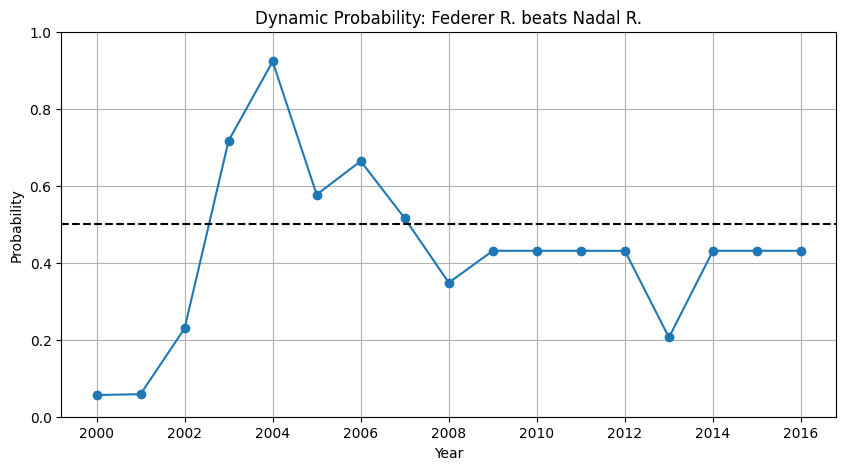

Dynamic Model Test Loss: 0.55351


In [53]:
REF_PLAYER = "Agassi A."
df_train, df_test = load_and_preprocess(df)
df_full = pd.concat([df_train, df_test])
base_vars, drift_vars, all_years = get_feature_definitions(df_full, REF_PLAYER)

print(f"Base Parameters: {len(base_vars)}")
print(f"Drift Parameters: {len(drift_vars)}")

X_train, y_train = build_dynamic_matrix(df_train, base_vars, drift_vars, REF_PLAYER)
X_test, y_test = build_dynamic_matrix(df_test, base_vars, drift_vars, REF_PLAYER)
final_betas, optimal_lambda = train_dynamic_model(X_train, y_train, len(base_vars))
plot_rivalry(final_betas, "Federer R.", "Nadal R.", all_years, base_vars, drift_vars, REF_PLAYER)
test_loss = evaluate_test_loss(X_test, y_test, final_betas)

print(f"Dynamic Model Test Loss: {test_loss:.5f}")

The dynamic model achieves the lowest loss as it accounts for the fact that a player's ability may change. It correctly penalises matches based on the current form of the players rather than an verage. The static model performs worse because it assumes a player's skill is constant forever. The surface model can perform well, but the dynamic model is superior for predicting outcomes over time, whereas the surface model is superior for predicting outcomes on specific courts. Potentially both approaches could be combined.